<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado_semifinal_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [ ]:
import pandas as pd
import numpy as np
# Nuestro paquete
import nlp

In [ ]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweety

# Carga de datos limpios

In [ ]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving testdata.manual.2009.06.14.csv to testdata.manual.2009.06.14.csv


In [ ]:
data = pd.read_csv('1600000_datos_limpios_sin_user_ni_url.csv',
                 encoding='utf-8')

In [ ]:
print(data.shape)

(1600000, 8)


In [ ]:
data.head()

,Unnamed: 0,target,ids,date,flag,user,text,raw_text
0,0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0       0
target           0
ids              0
date             0
flag             0
user             0
text          8494
raw_text         0
dtype: int64


In [ ]:
data = data[data.text.notna()]

In [ ]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
raw_text      0
dtype: int64


In [ ]:
len(data)

1591506

## Buscamos 20,000 datos para entrenar y 2 mil para probar que sean cercano a la misma longitud


## Entrenamos un Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [ ]:
max_words = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.text)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 330671
[('go', 1), ('get', 2), ('day', 3), ('good', 4), ('work', 5), ('like', 6), ('love', 7), ('got', 8), ('today', 9), ('time', 10)]


In [ ]:

# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(data.text)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

Tweet más pequeño 0 words.
Tweet más grande 27 words.
Longitud promedio: 4.96 +- 3.04 words.




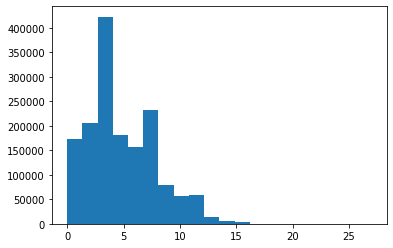

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths,20)
plt.show()

In [ ]:
train_seq = np.array(train_sequences, dtype=object)
df_sequences = pd.DataFrame(train_seq.T, columns=['tokens'])

In [ ]:
df_sequences['len'] = df_sequences['tokens'].map(lambda s: len(s))

In [ ]:
data = data.reset_index().drop(['index', 'Unnamed: 0'], axis = 1)
data

,target,ids,date,flag,user,text,raw_text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...,...
1591501,1,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feel ever,just woke up. having no school is the best fee...
1591502,1,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interview,thewdb.com - very cool to hear old walt interv...
1591503,1,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,readi mojo makeov ask detail,are you ready for your mojo makeover? ask me f...
1591504,1,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happi 38th birthday boo time tupac amaru shakur,happy 38th birthday to my boo of alll time!!! ...


In [ ]:
df_sequences['target'] = data['target']

In [ ]:
df_sequences

,tokens,len,target
0,"[110, 8, 697, 3]",4,0
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188]",10,0
2,"[221, 10, 860, 686, 495, 344, 1]",7,0
3,"[327, 645, 19, 6, 863]",5,0
4,"[454, 18]",2,0
...,...,...,...
1591501,"[248, 76, 103, 19, 149]",5,1
1591502,"[122, 174, 159, 752]",4,1
1591503,"[134, 287]",2,1
1591504,"[53, 183, 296, 10]",4,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


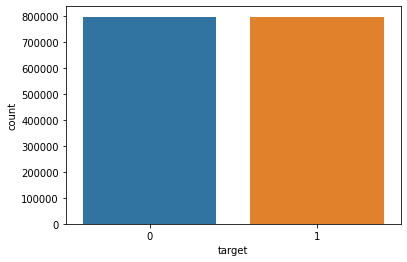

In [ ]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(df_sequences['target'])

# Hacemos padding

In [ ]:
last_df = df_sequences

In [ ]:
#sequences = tokenizer.texts_to_sequences(data_set_1.text)
max_len = 11
tweets = pad_sequences(list(last_df.tokens), maxlen=max_len, padding='post')
print(tweets)

[[110   8 697 ...   0   0   0]
 [592 222 430 ...   9 188   0]
 [221  10 860 ...   0   0   0]
 ...
 [134 287   0 ...   0   0   0]
 [ 53 183 296 ...   0   0   0]
 [ 53   0   0 ...   0   0   0]]


## Separamos en train, test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets, last_df.target.values, test_size=0.3, random_state=23042021)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1114054, 11)
y_train (1114054,)
X_test (477452, 11)
y_test (477452,)


# Creamos el modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 12)            12000     
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                2400      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 15,025
Trainable params: 15,025
Non-trainable params: 0
____________________________________________________

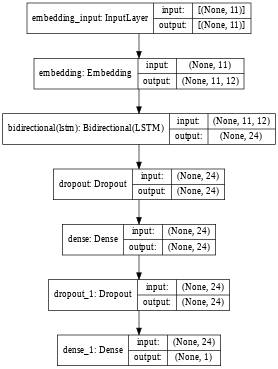

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='rmsprop', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [ ]:
# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
13926/13926 [==============================] - 139s 8ms/step - loss: 0.5472 - binary_accuracy: 0.7244 - accuracy: 0.7244 - val_loss: 0.5083 - val_binary_accuracy: 0.7463 - val_accuracy: 0.7463
Epoch 2/20
13926/13926 [==============================] - 107s 8ms/step - loss: 0.5198 - binary_accuracy: 0.7479 - accuracy: 0.7479 - val_loss: 0.5117 - val_binary_accuracy: 0.7463 - val_accuracy: 0.7463
Epoch 3/20
13926/13926 [==============================] - 105s 8ms/step - loss: 0.5176 - binary_accuracy: 0.7505 - accuracy: 0.7505 - val_loss: 0.5064 - val_binary_accuracy: 0.7493 - val_accuracy: 0.7493
Epoch 4/20
13926/13926 [==============================] - 104s 7ms/step - loss: 0.5166 - binary_accuracy: 0.7512 - accuracy: 0.7512 - val_loss: 0.5044 - val_binary_accuracy: 0.7501 - val_accuracy: 0.7501
Epoch 5/20
13926/13926 [==============================] - 103s 7ms/step - loss: 0.5150 - binary_accuracy: 0.7526 - accuracy: 0.7526 - val_loss: 0.5042 - val_binary_accuracy: 0.7506 - v

In [ ]:
model.evaluate(x=X_test, y=y_test)

14921/14921 [==============================] - 43s 3ms/step - loss: 0.5102 - binary_accuracy: 0.7518 - accuracy: 0.7518


[0.5102328062057495, 0.7518430948257446, 0.7518430948257446]

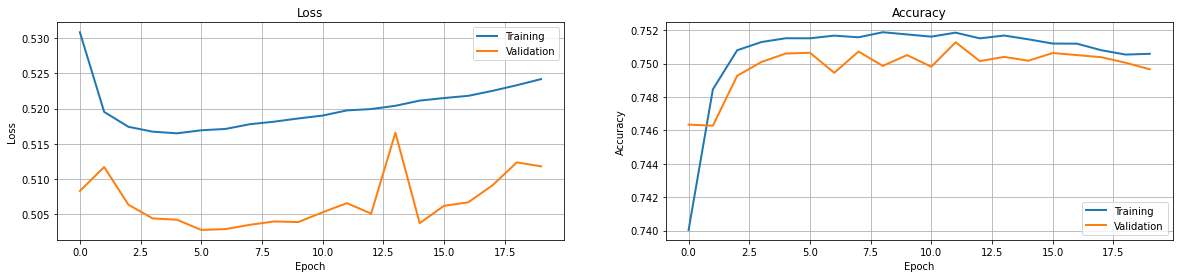

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
score = model.predict(test)

if score<=0.5:
  print("Negativo")
else:
  print("Positivo")

print(score)

Positivo
[[0.70507073]]


In [ ]:
from tensorflow.keras.models import save_model, load_model

In [ ]:
# Para guardar el modelo
save_model(model, "./")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [ ]:
# Para cargar el modelo y poder utilizar el .predict
m_loaded = load_model("./")

In [ ]:
sequence = tokenizer.texts_to_sequences(['yahoo answers can be a butt sometimes'])
test = pad_sequences(sequence, maxlen=max_len)
score = model.predict(test)

if score<=0.5:
  print("Negativo")
else:
  print("Positivo")

print(score)

Positivo
[[0.56445104]]


## Pruebas con otros datos

In [ ]:
test_data =  pd.read_csv('testdata.manual.2009.06.14.csv',
                 encoding='latin-1', names=col_names)

In [ ]:
test_data

,target,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [ ]:
from nlp.preprocessing import convierte_a_minusculas, quitar_caracteres_html, reemplazar_urls, reemplazar_usuarios,\
quitar_hashtag, quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas, quitar_nonascii, \
separar_abreviaciones, remove_stopwords, oracion_raiz, modificar_etiqueta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_raw = test_data

In [ ]:
data = convierte_a_minusculas(data_raw)
data['text'] = data['text'].map(lambda s: quitar_caracteres_html(s))
data['text'] = data['text'].map(lambda s: reemplazar_urls(s))
data['text'] = data['text'].map(lambda s: reemplazar_usuarios(s))
data['text'] = data['text'].map(lambda s: quitar_hashtag(s))
data['text'] = data['text'].map(lambda s: quitar_RT(s))
data['text'] = data['text'].map(lambda s: quitar_caracteres_especiales(s))
data['text'] = data['text'].map(lambda s: quitar_letras_repetidas(s))
data['text'] = data['text'].map(lambda s: quitar_nonascii(s))
data['text'] = data['text'].map(lambda s: separar_abreviaciones(s))
data['text'] = data['text'].map(lambda s: remove_stopwords(s))
data['text'] = data['text'].map(lambda s: oracion_raiz(s))
data = modificar_etiqueta(data)

In [ ]:
data = data[data['target']!=2]

In [ ]:
test_data = test_data[test_data['target']!=2]


In [ ]:
sequence = tokenizer.texts_to_sequences(data['text'])
test = pad_sequences(sequence, maxlen=max_len)
score = model.predict(test)

In [ ]:
pd.set_option('display.max_colwidth', None)


In [ ]:
score_1=pd.DataFrame(score, columns=['score'])


In [ ]:
score_1['predict_label'] = score_1.score.map(lambda s: 'positive' if s>=0.5 else 'negative')
score_1['real_label'] = data['target'].values
score_1['texto'] = data['text'].values
score_1['texto_raw'] = test_data['text'].values

In [ ]:
score_1['ground_truth'] = score_1.real_label.map(lambda s: 'positive' if s==1 else 'negative')

In [ ]:
1 - (len(score_1[score_1['predict_label']!=score_1['ground_truth']]) / len(score_1))

0.766016713091922

In [ ]:
(len(score_1[score_1['predict_label']!=score_1['ground_truth']]) / len(score_1))

0.233983286908078